In [1]:
from warnings import filterwarnings

In [2]:
filterwarnings('ignore')

In [3]:
from fastai.metrics import *

In [4]:
from fastai.vision import *

In [5]:
import json

In [6]:
import pandas as pd

In [7]:
p = Path('../kaggle_resized')

In [8]:
j = json.load(open('../train.json'))

In [9]:
df = pd.DataFrame({'fnames': list(p.iterdir())})

In [10]:
df.shape

(746436, 1)

In [11]:
df['image_id'] = df.fnames.apply(lambda x: int(str(x).split('/')[-1].split('.')[0]))

In [12]:
anno = {int(k['imageId']): k['labelId'] for k in j['annotations']}

![](../kaggle_resized/1061.jpg)

In [13]:
df['cats'] = df.image_id.apply(lambda x: anno[x])

In [14]:
df['cats'] = df['cats'].apply(lambda x: ','.join(x))

In [15]:
df['fnames'] = df.fnames.astype('str')

In [16]:
df['fnames'] = df.fnames.apply(lambda x: x.split('/')[-1])

In [17]:
df[['fnames', 'cats']].to_csv('../MC.csv', index=False)

In [18]:
!head ../MC.csv

fnames,cats
317667.jpg,"36,66,44,116,171,133"
234228.jpg,"19,131,17,222,66,137,214,155,164,128"
679698.jpg,"18,19,66,98,214,105,63"
561191.jpg,"66,53,205,105,204"
513358.jpg,"66,116,105"
657992.jpg,"227,78,131,17,66,137"
509643.jpg,"193,66,137,144,75,171"
351500.jpg,"62,19,17,222,148,66,116,171,133"
512178.jpg,"127,17,66"


In [19]:
from PIL import Image

In [53]:
def check_im(fname):
    try:
        im = Image.open('../kaggle_resized/' + fname)
        return im.size
    except Exception as e:
        print(fname, e)
        return fname

In [54]:
im = check_im('../kaggle_resized/100006.jpg')

In [55]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from fastprogress import progress_bar

In [56]:
def parallel(func, job_list, n_jobs=4):
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        futures = [pool.submit(func, job) for job in job_list]
        for f in progress_bar(as_completed(futures), total=len(job_list)):
            pass
    return [f.result() for f in futures]

In [57]:
res = parallel(check_im, df.fnames.values.tolist())

In [59]:
[r for r in res if r != (512, 512)]

[]

In [20]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [21]:
data = ImageDataBunch.from_csv('../', 'kaggle_resized', label_delim=',', bs=64,
                               valid_pct=0.1, csv_labels='MC.csv' ,label_col='cats')

In [22]:
data

ImageDataBunch;

Train: LabelList (671793 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
36;66;44;116;171;133,19;131;17;222;66;137;214;155;164;128,18;19;66;98;214;105;63,66;53;205;105;204,66;116;105
Path: ..;

Valid: LabelList (74643 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
17;66;97;98;153;171,61;106;49;105,66;65;70;63,62;66;98;116;171;20,190;17;106;53;153;164;138
Path: ..;

Test: None

In [23]:
len(data.classes)

228

In [24]:
data.c

228

In [25]:
f_model=models.resnet34
sz=512
bs=128

In [171]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

learn = cnn_learner(data, f_model, metrics=[acc_02, f_score])
# learn = cnn_learner(data, f_model)

In [27]:
learn.freeze_to(-2)

In [51]:
lrf=learn.lr_find(1e-5,100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


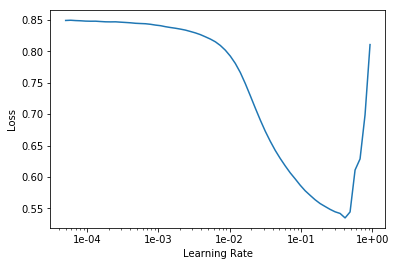

In [52]:
learn.recorder.plot()

In [28]:
lr = 3e-2

In [29]:
learn.fit_one_cycle(cyc_len=1, max_lr=lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.058873,0.065843,0.974081,0.571514,1:02:29


In [32]:
learn.save('stage-1')

In [35]:
learn.freeze_to(-5)

In [36]:
lrf=learn.lr_find(1e-6,100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


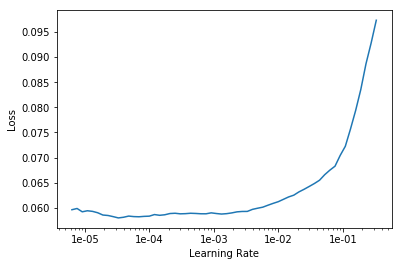

In [37]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(cyc_len=1, max_lr=5e-5)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.058508,0.111706,0.974551,0.577164,1:19:23


In [39]:
learn.save('second')

In [40]:
!ls ../models/

second.pth  stage-1.pth  tmp.pth


In [172]:
learn.load('stage-1');

In [173]:
learn.model.eval();

In [44]:
learn.model._modules

OrderedDict([('0', Sequential(
                (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace)
                (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                (4): Sequential(
                  (0): BasicBlock(
                    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    (relu): ReLU(inplace)
                    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  )
                  (1): BasicBlock(
                    (conv1): Conv2d(64, 64, ke

In [47]:
layer = learn.model._modules.get('1')._modules.get('7')

In [48]:
layer

Dropout(p=0.5)

In [49]:
from torchvision import transforms

In [50]:
scaler = transforms.Scale((512, 512))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [51]:
import torch
from torch.autograd import Variable

In [52]:
from PIL import Image

In [100]:
def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)

    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512

    my_embedding = torch.zeros((1, 512))

    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)

    # 6. Run the model on our transformed image
    learn.model(t_img.cuda())

    # 7. Detach our copy function from the layer
    h.remove()

    # 8. Return the feature vector
    return my_embedding

In [83]:
pic_name = '../kaggle_resized/100000.jpg'

In [84]:
pic_one_vector = get_vector(pic_name)

In [85]:
df.shape

(746436, 3)

In [86]:
df.head()

,fnames,image_id,cats
0,317667.jpg,317667,"36,66,44,116,171,133"
1,234228.jpg,234228,"19,131,17,222,66,137,214,155,164,128"
2,679698.jpg,679698,"18,19,66,98,214,105,63"
3,561191.jpg,561191,"66,53,205,105,204"
4,513358.jpg,513358,"66,116,105"


In [87]:
pic_one_vector.numpy()

array([[-0.016434,  0.043987, -0.004513, -0.035484, ...,  0.00581 , -0.061593, -0.004153,  0.012643]], dtype=float32)

In [88]:
from fastprogress import progress_bar

In [101]:
emb_dict = {}

In [102]:
res = []

In [111]:
learn.model.cuda();

In [112]:
learn.model.eval();

In [103]:
def get_emb(fname):
    return (fname[:-4], get_vector('../kaggle_resized/' + fname).numpy())

In [104]:
res = parallel(get_emb, df.fnames.values.tolist()[:5])

In [105]:
res

In [76]:
get_emb('317667.jpg')

('317667',
 array([[-0.016434,  0.080446, -0.004513, -0.034239, ...,  0.00581 , -0.123593, -0.004153,  0.012643]], dtype=float32))

In [107]:
for fname in progress_bar(df.fnames, total=df.shape[0]):
    vec = get_vector('../kaggle_resized//' + fname)
    emb_dict[fname[:-4]] = vec.numpy()

In [115]:
len(emb_dict)

81058

In [186]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [164]:
sf = SaveFeatures(learn.model[1][5])

In [124]:
# _= learn.get_preds(data.train_ds)

In [126]:
len(sf.features)

330304

In [130]:
image_id = [i.split('/')[-1][:-4] for i in list(data.train_ds.items)[:330304]]
feature_dict = dict(zip(image_id, sf.features))

In [131]:
import pickle

In [132]:
pickle.dump(feature_dict, open("../models/feature_dict_train.p", "wb"))

In [135]:
from annoy import AnnoyIndex

In [136]:
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [137]:
def multi_plot(fnames, ncols=3):
    """
        Display multiple images in a grid structure
        fnames: list of file name with full/relative path
    """
    assert ncols != 0
    no_imgs = len(fnames)
    nrows = math.ceil(no_imgs / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows),
                             subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for ax, fname in zip(axes.flat, fnames):
        im = Image.open(fname)
        ax.imshow(im)
        ax.set_title(fname.split('/')[-1], size=20)
    plt.tight_layout()
    plt.show()

In [138]:
f = 512

In [145]:
t = AnnoyIndex(f)

In [146]:
for k,v in feature_dict.items():
    t.add_item(int(k), v)

In [147]:
t.build(100)

True

In [148]:
t.save('train.ann')

True

In [149]:
u = AnnoyIndex(f)

![](../kaggle_resized/137654.jpg)

`137654`

In [152]:
t.get_nns_by_item(137654, 12)

[137654,
 233630,
 430854,
 27511,
 771295,
 268151,
 654144,
 685442,
 676693,
 704668,
 282656,
 238241]

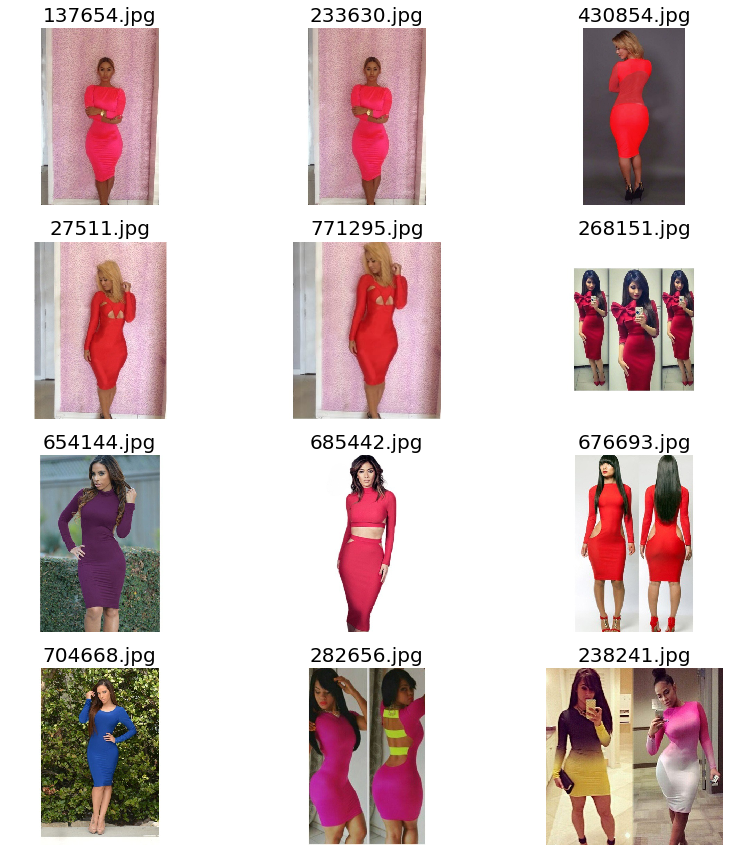

In [154]:
multi_plot([f'../kaggle_resized/{i}.jpg' for i in t.get_nns_by_item(137654, 12)])

In [156]:
p2 = Path('../product_resized/')

In [158]:
df2 = pd.DataFrame({'fnames': list(p2.iterdir())})

In [160]:
df2['cats'] = np.random.choice([1, 2], size=df2.shape[0])

In [161]:
df2.head()

,fnames,cats
0,../product_resized/22055.jpg,2
1,../product_resized/15549.jpg,1
2,../product_resized/6109.jpg,2
3,../product_resized/19364.jpg,1
4,../product_resized/20767.jpg,1


In [214]:
data3 = ImageDataBunch.from_df('../product_resized/', df2, label_col='cats', bs=128)

In [215]:
data2 = ImageDataBunch.single_from_classes('../', data.classes, size=512).normalize(imagenet_stats)

In [244]:
learn2 = cnn_learner(data2, f_model)

In [245]:
learn2.load('stage-1');

In [246]:
learn2.model.eval();

../product_resized/../product_resized/9081.jpg


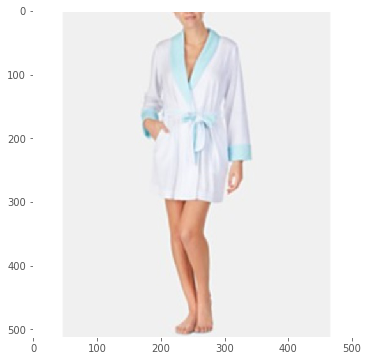

In [283]:
fname = data3.train_ds.items[500]
print(fname)
plt.imshow(Image.open(fname))
plt.grid(False);

In [284]:
sf = SaveFeatures(learn2.model[1][5])
img = Image.open(fname)
t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
_ = learn2.model(t_img.cuda())

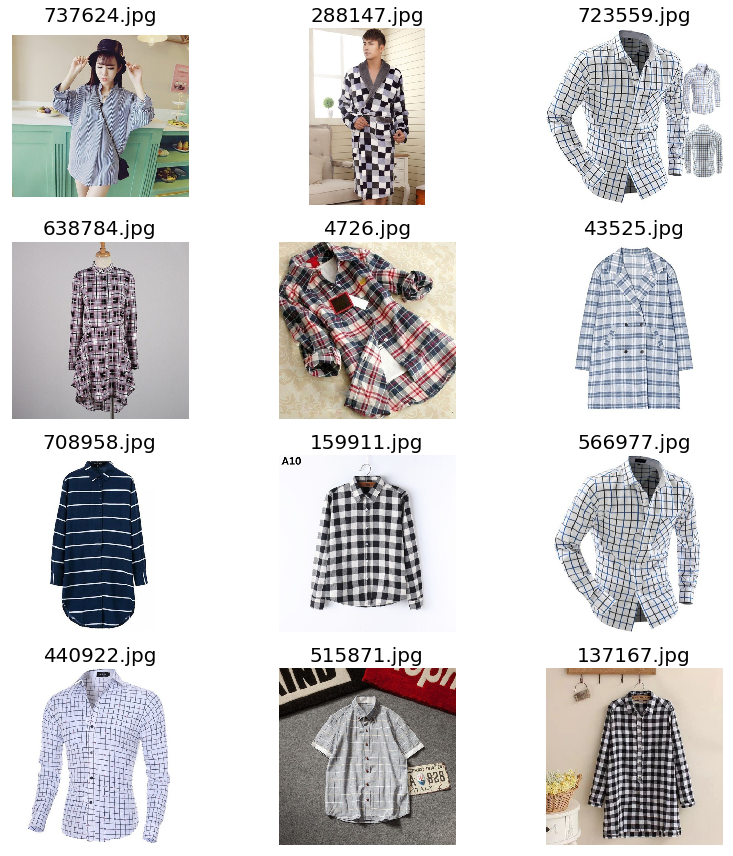

In [285]:
multi_plot([f'../kaggle_resized/{i}.jpg' for i in t.get_nns_by_vector(sf.features[0], 12)])